# Basic demo of training GNN on boid model.
All the scripts are in **scripts.gnn.gnn** and **scripts.gnn.gnn_definition**.
The scripts build barebone GNN network architecture, handling of discrete data. 
The notebook illustrates training and testing and demos of single-frame prediction.

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [3]:
from itertools import combinations
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from collab_env.data.file_utils import expand_path, get_project_root

In [80]:
from collab_env.gnn.gnn import get_adjcency_from_debug, plot_log_loss, train_rules_gnn, load_model, save_model, debug_result2prediction
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets
from collab_env.gnn.utility import dataset2testloader
from itertools import product

### 1. Load data

#### (A) Boid with boundary
#### (B) Independent with boundary
#### (C) Boid with boundary and food
#### (D) Independent with boundary and food
#### (E) Boid with boundary and strong influence food

In [127]:
data_names = ['boid_single_species_basic', 'boid_single_species_independent', # without food
              'boid_food_basic_alignment', 'boid_food_basic_independent', # with food
              'boid_food_strong'] # with food, strong influence

BATCH_SIZE = 10
data = {}

for data_name in data_names:
    file_name = f'{data_name}.pt'
    config_name = f'{data_name}_config.pt'
    
    dataset = torch.load(expand_path(
            "simulated_data/" + file_name, get_project_root()), weights_only = False)
    species_configs = torch.load(expand_path(
            "simulated_data/" + config_name, get_project_root()), weights_only = False)

    test_loader, train_loader = dataset2testloader(dataset, batch_size = batch_size,
                                                   return_train = True)

    data[data_name] = {}
    data[data_name]["data_name"] = data_name
    data[data_name]["file_name"] = file_name
    data[data_name]["config_name"] = config_name
    data[data_name]["dataset"] = dataset
    data[data_name]["species_configs"] = species_configs
    data[data_name]['test_loader'] = test_loader
    data[data_name]['train_loader'] = train_loader


/workspace/conda/envs/gnn/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### 2. Train GNN and our lazyGNN
The lazy model only outputs a zero acceleration at all frames.

In [128]:
def make_specs(data_name, model_name,
               noise_level, head, visual_range, epoch):
    """
    data_name: name of the dataset
    model_name: name of th
    """

    if "food" in data_name:
        in_node_dim = 20
    else:
        in_node_dim = 19

    if "lazy" in model_name:
        model_spec_lazy = {
            "model_name": "lazy",
            "prediction_integration": "Euler",  # predict model acceleration
            "input_differentiation":"finite",
            "in_node_dim": 3,
            "start_frame": 3,
            "heads": 1}

        train_spec_lazy = {
            "lr": None,
            "visual_range": visual_range,
            "sigma": sigma,
            "epochs": 1}
        
        return model_spec_gnn, train_spec_gnn
    
    model_spec_gnn = {
        "model_name": "vpluspplus_a",
        "node_feature_function": "vel_plus_pos_plus",  # features are velocity(t-2), velocity(t-1), velocity(t)
        "node_prediction": "acc",  # predict model acceleration
        "prediction_integration": "Euler",  # predict model acceleration
        "input_differentiation": "finite",
        "in_node_dim": in_node_dim,
        "start_frame": 3,
        "heads": head
    }

    train_spec_gnn = {
        "lr": 1e-4,
        "visual_range": visual_range,
        "epochs": epoch,
        "sigma": noise_level,
        "training": True
    }
    
    return model_spec_gnn, train_spec_gnn

In [129]:
def initialize_models(model_name, model_spec, train_spec):
    gnn_model: torch.nn.Module | None = None
        
    # initialize models
    if "lazy" in model_name:
        training = False
        gnn_model = Lazy(
            **model_spec
        )
    
    else:
        training = True
        gnn_model = GNN(
            **model_spec
        )

    train_spec["training"] = training

    return gnn_model, train_spec

In [130]:
def train(data, model_spec, train_spec, seed, save_name_postfix):
    torch.cuda.empty_cache()
    torch.manual_seed(seed)  # PyTorch CPU and CUDA

    m = model_spec["model_name"]
        
    result = {}
    
    gnn_model, train_spec = initialize_models(m, model_spec, train_spec)
    
    # data
    data_name = data['data_name']
    train_loader = data['train_loader']
    species_dim = len(data['species_configs'].keys())
        
    
    # train models
    (result["train_losses"], result["model"], result["debug_result"]) = (
        train_rules_gnn(
            gnn_model,
            train_loader,
            species_dim = species_dim,
            **train_spec
            )
        )
    
    #models[m]["W_input"], models[m]["W_output"] = get_adjcency_from_debug(
    #    models[m]["debug_result"], train_loader, visual_range
    #)

    gnn_model = result["model"]
    noise_level = train_spec["sigma"]
        
    file_name = f"{data_name}_{m}_{save_name_postfix}_seed{seed}"
    save_model(result["model"], model_spec, train_spec, file_name)
    
    return np.sum(result["train_losses"])
    

In [126]:
model_names = ["vpluspplus_a", "lazy"]
noise_levels = [0, 0.005]
heads = [1, 2, 3]
visual_ranges = [0.2, 0.5]

all_combinations = list(product(data_names, model_name, noise_levels, heads, visual_ranges))

EPOCH = 1 #20
SEED_NUM = 5

for (data_name, model_name, noise, head, visual_range) in all_combinations[:1]:
    model_spec, train_spec = make_specs(data_name, model_name,
                                        noise, head, visual_range, EPOCH)
    save_name_postfix = f"noise{noise}_head{head}_visual_range{visual_range}"
    
    for seed in range(SEED_NUM):
        loss = train(data[data_name], model_spec, train_spec, seed, save_name_postfix)
    

epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


Epoch 000 | Train: 0.0031
Saved model to /workspace/collab-environment/trained_models/boid_single_species_basic_vpluspplus_a_noise0_head1_visual_range0.2_seed0.pt.
epoch 0


batch 0




KeyboardInterrupt: 

In [117]:
result["train_losses"].shape

NameError: name 'result' is not defined

In [121]:
%debug

> /tmp/ipykernel_13766/1118675509.py(37)train()
     35     save_model(result["model"], model_spec, train_spec, file_name)
     36 
---> 37     assert 1 == 0
     38     return np.sum(result["train_losses"])
     39 



ipdb>  np.sum(result["train_losses"])


np.float64(0.025376585848366773)


ipdb>  exit


In [13]:
print("done")

done


### Below needs update Aug 20, 2025

### 3. Investigate loss 

In [ ]:
loss_all = [models[m]["train_losses"] for m in ["vpluspplus_a"]]

loss_all.append(np.tile(models["lazy"]["train_losses"], (loss_all[0].shape[0], 1)))

plot_log_loss(
    loss_all, [m for m in models], alpha=0.05, title="Training loss (acceleration)"
)
plt.show()

# loss_all = [models[m]["train_losses"] for m in models]
# plot_log_loss(loss_all,[m for m in models],
#              alpha = 0.05,
#              title = "Training loss")

### MSE on position prediction

In [132]:
# TO DO: move this into a function
loss_mse_all = {}
for m in models:
    loss_m = []
    epoch_num = list(models[m]["debug_result"].keys())[-1]

    for file_id in models[m]["debug_result"][epoch_num].keys():

        actual = np.concatenate(
            models[m]["debug_result"][epoch_num][file_id]["actual"], axis=0
        )
        predicted = np.concatenate(
            models[m]["debug_result"][epoch_num][file_id]["predicted"], axis=0
        )

        loss = functional.mse_loss(
            torch.tensor(actual), torch.tensor(predicted)
        )  # + 0.1 * torch.sum(edge_weight)
        loss_m.append(loss)
    loss_mse_all[m] = loss_m

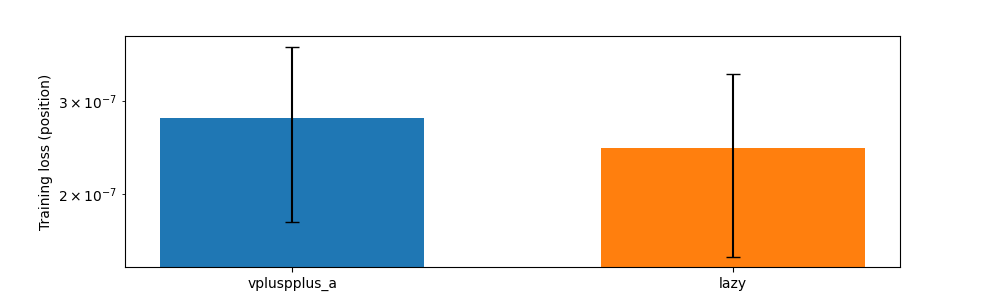

In [133]:
# plot all models
fig, ax = plt.subplots(figsize=(10, 3))

ind = 0
for m in models:
    name = m
    mean = np.mean(loss_mse_all[m])
    std_devs = 2 * np.std(loss_mse_all[m])
    ax.bar(ind, mean, width=0.6)
    ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color="black", capsize=5)

    ind += 1
ax.set_xticks(np.arange(len(models)), labels=[m for m in models])
ax.set_ylabel("Training loss (position)")
plt.yscale("log", base=10)
plt.show()

### To investigate one model on one file

#### a) video, overlay trajectories on top of each other.

In [26]:
file_id = 2
epoch_num = 2

m = "vpluspplus_a"
rollout_debug_result = models[m]["debug_result"]
actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_debug_result,
                    file_id = file_id, epoch_num = epoch_num)



p0 shape torch.Size([20, 2])
p shape torch.Size([996, 20, 2])


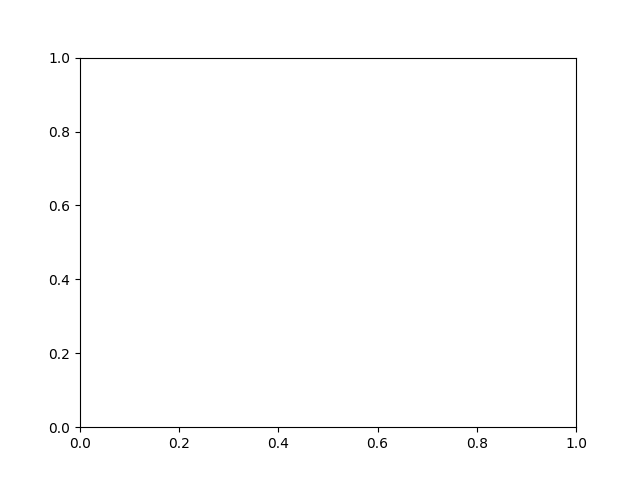

In [33]:
%matplotlib widget
starting_frame = 0
ending_frame = 300
ani, ax = visualize_graph_2sets(actual_pos[0], None, gnn_pos[0], None,
                starting_frame = starting_frame, ending_frame = ending_frame,
                file_id = 0)

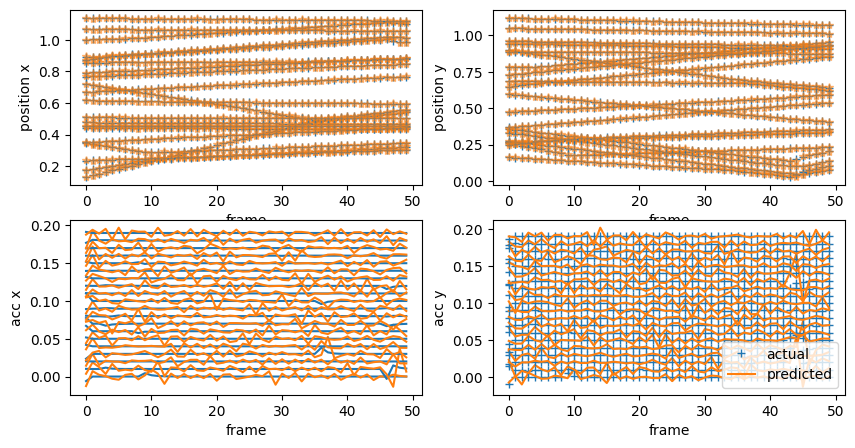

In [41]:
%matplotlib inline
ending_frame = 50
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax = ax.ravel()

for b in np.arange(20):
    if b == 0:
        label1, label2 = "actual","predicted"
    else:
        label1, label2 = None, None

    ax[0].plot(actual_pos[0, starting_frame:ending_frame, b, 0] + 0.01 * b, "+", color = 'C0', label= label1)
    ax[0].plot(gnn_pos[0, starting_frame:ending_frame, b, 0] + 0.01 * b, "*", color = 'C1',label = label2, alpha=0.5)
    
    
    ax[1].plot(actual_pos[0, starting_frame:ending_frame, b, 1] + 0.01 * b, "+", color = 'C0', label=label1)
    ax[1].plot(gnn_pos[0, starting_frame:ending_frame, b, 1] + 0.01 * b, "*", color = 'C1',label=label2, alpha=0.5)
    
    
    ax[2].plot(actual_acc[0, starting_frame:ending_frame, b, 0] + 0.01 * b, color = 'C0', label=label1)
    ax[2].plot(gnn_acc[0, starting_frame:ending_frame, b, 0] + 0.01 * b, color = 'C1',label=label2)
    
    
    ax[3].plot(actual_acc[0, starting_frame:ending_frame, b, 1] + 0.01 * b, "+", color = 'C0', label=label1)
    ax[3].plot(gnn_acc[0, starting_frame:ending_frame, b, 1] + 0.01 * b, color = 'C1',label=label2)

    
ax[0].set_xlabel("frame")
ax[0].set_ylabel("position x")

ax[1].set_xlabel("frame")
ax[1].set_ylabel("position y")

ax[2].set_xlabel("frame")
ax[2].set_ylabel("acc x")

#ax[3].plot(loss_acc, label="acc loss")
ax[3].set_xlabel("frame")
ax[3].set_ylabel("acc y")

plt.legend()
plt.show()

#### b) visualize the dynamic weight matrices
Because the attention layer is a function 
$$
A: F \times F \rightarrow \mathbb{R},
$$
 where $F$ is the space of node feature, a subset of $\mathbb{R}^n$, n is the dimensionality of the input layer size, we obtain dynamic adjacency matrix as boids move around producing dynamic node features.

In [42]:
m = "vpluspplus_a"
W_output = models[m]["W_output"]

In [43]:
# choose a file
file_id = 3

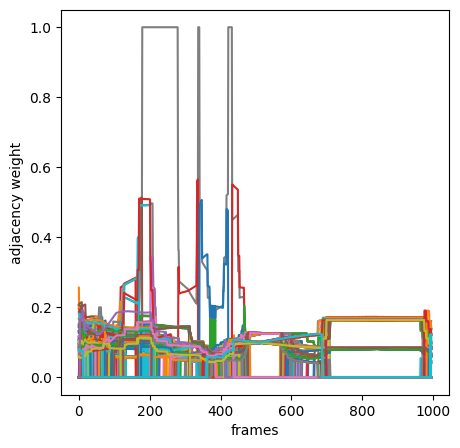

In [44]:
%matplotlib inline

final_epoch = list(W_output.keys())[-1]
W_output_overtime = W_output[final_epoch][file_id]
frames = np.arange(0, len(W_output_overtime))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pairs = combinations(np.arange(np.shape(W_output_overtime[0])[0]), 2)
for p in pairs:
    W_output_overtime_ij = [W_output_overtime[t][p[0], p[1]] for t in frames]
    plt.plot(frames, W_output_overtime_ij)
plt.xlabel("frames")
plt.ylabel("adjacency weight")
plt.show()

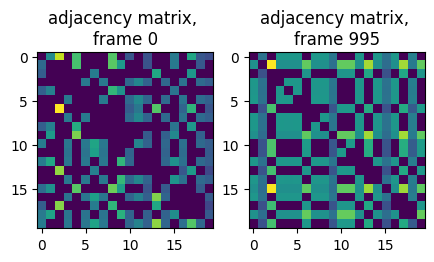

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
f0 = 0
f1 = len(W_output_overtime) - 1
ax[0].imshow(W_output_overtime[f0])
ax[0].set_title(f"adjacency matrix, \nframe {f0}")
ax[1].imshow(W_output_overtime[f1])
ax[1].set_title(f"adjacency matrix, \nframe {f1}")
plt.show()

## 4. Validate on held-out dataset

In [67]:
# load model
models_reload = {}
model_spec_reload = {}
train_spec_reload = {}

for m in ["vpluspplus_a", "lazy"]:
    file_name = f"{data_name}_{m}_noise_{sigma}"
    models_reload[m] = {}
    models_reload[m]["model"], model_spec_reload[m], train_spec_reload[m] = load_model(m, file_name)
    

Loaded model spec.
Loaded training spec.
Loaded model.
Loaded model spec.
Loaded training spec.
Loaded lazy model.


In [63]:
torch.cuda.empty_cache()

In [68]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloader_list = list(test_loader)

In [72]:
for m in models_reload:
    
    gnn_model = models_reload[m]["model"]
    gnn_training_spec = train_spec_reload[m]

    gnn_training_spec["training"] = False
    gnn_training_spec["lr"] = None

    # train models
    (models_reload[m]["test_losses"], _, models_reload[m]["test_debug_result"]) = train_rules_gnn(
        gnn_model,
        test_loader,
        species_dim=len(torch.unique(species)),
        **gnn_training_spec
    )

    models_reload[m]["test_W_input"], models_reload[m]["test_W_output"] = get_adjcency_from_debug(
        models_reload[m]["test_debug_result"], test_loader, gnn_training_spec["visual_range"]
    )

epoch 0


batch 0




/workspace/collab-environment/collab_env/gnn/gnn.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(pos)
/workspace/collab-environment/collab_env/gnn/gnn.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vel = torch.tensor(vel)
/workspace/collab-environment/collab_env/gnn/gnn.py:382: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.tensor(acc)
/workspace/collab-environment/collab_env/gnn/gnn.py:443: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or so

batch 1


batch 2




/workspace/collab-environment/collab_env/gnn/gnn.py:210: RuntimeWarning: invalid value encountered in divide
  A_output = A / col_sum[np.newaxis, :]


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 0.0032
finished one epoch
epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 0.0003
finished one epoch


### Acceleration loss

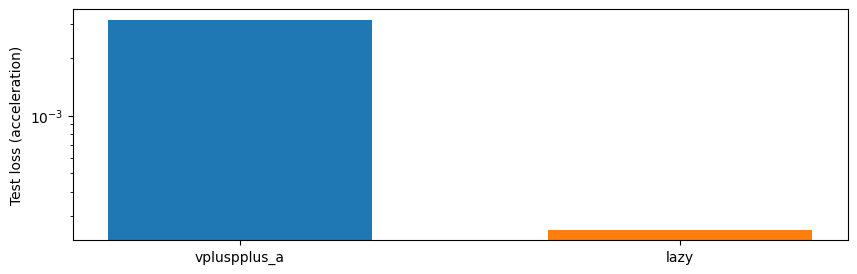

In [74]:
# plot all models
fig, ax = plt.subplots(figsize=(10, 3))

ind = 0
for m in models:
    name = m
    mean = np.mean(models_reload[m]["test_losses"])
    std_devs = 2 * np.std(models_reload[m]["test_losses"])
    ax.bar(ind, mean, width=0.6)
    # ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color='black', capsize=5)

    ind += 1
ax.set_xticks(np.arange(len(models_reload)), labels=[m for m in models_reload])
ax.set_ylabel("Test loss (acceleration)")
plt.yscale("log", base=10)
plt.show()

### MSE position loss

In [75]:
test_loss_mse_all = {}
for m in models_reload:
    loss_m = []
    epoch_num = list(models_reload[m]["test_debug_result"].keys())[-1]

    for file_id in models_reload[m]["test_debug_result"][epoch_num].keys():

        actual = np.concatenate(
            models_reload[m]["test_debug_result"][epoch_num][file_id]["actual"], axis=0
        )
        predicted = np.concatenate(
            models_reload[m]["test_debug_result"][epoch_num][file_id]["predicted"], axis=0
        )

        loss = functional.mse_loss(
            torch.tensor(actual), torch.tensor(predicted)
        )  # + 0.1 * torch.sum(edge_weight)
        loss_m.append(loss)
    test_loss_mse_all[m] = loss_m

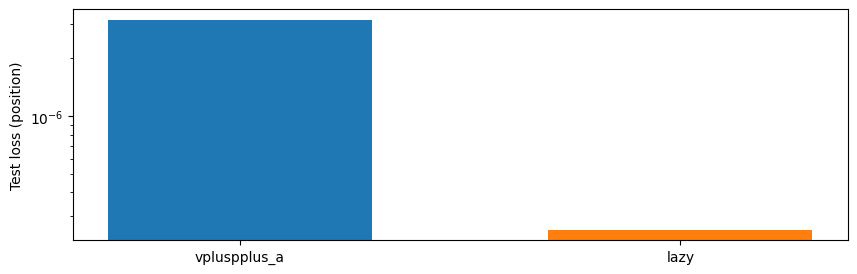

In [76]:
# plot all models
fig, ax = plt.subplots(figsize=(10, 3))

ind = 0
for m in models_reload:
    name = m
    mean = np.mean(test_loss_mse_all[m])
    std_devs = 2 * np.std(test_loss_mse_all[m])
    ax.bar(ind, mean, width=0.6)
    # ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color='black', capsize=5)

    ind += 1
ax.set_xticks(np.arange(len(models_reload)), labels=[m for m in models_reload])
ax.set_ylabel("Test loss (position)")
plt.yscale("log", base=10)
plt.show()

### plot all birds

In [79]:
file_id = 8

m = "vpluspplus_a"
rollout_debug_result = models_reload[m]["test_debug_result"]
actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_debug_result,
                    file_id = file_id, epoch_num = 0)

## 5. Rollout on test dataset

In [81]:
rollout = 5 #the frame to start rollout

In [84]:
torch.cuda.empty_cache()

for m in ["vpluspplus_a"]:
    
    gnn_model = models_reload[m]["model"]
    gnn_training_spec = train_spec_reload[m]

    gnn_training_spec["training"] = False
    gnn_training_spec["lr"] = None
    gnn_training_spec["rollout"] = rollout

    # train models
    (models_reload[m]["rollout_losses"], _, models_reload[m]["rollout_debug_result"]) = train_rules_gnn(
        gnn_model,
        test_loader,
        species_dim=len(torch.unique(species)),
        **gnn_training_spec
    )

    models_reload[m]["rollout_W_input"], models_reload[m]["rollout_W_output"] = get_adjcency_from_debug(
        models_reload[m]["rollout_debug_result"], test_loader, gnn_training_spec["visual_range"])

epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 0.6638
finished one epoch


In [101]:
file_id = 9

m = "vpluspplus_a"
rollout_debug_result = models_reload[m]["rollout_debug_result"]
actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_debug_result,
                    file_id = file_id, epoch_num = 0)



p0 shape torch.Size([20, 2])
p shape torch.Size([996, 20, 2])


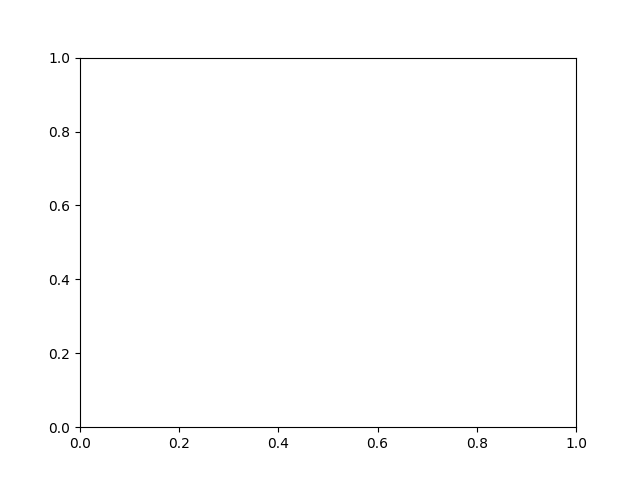

In [102]:
%matplotlib widget
starting_frame = 0
ending_frame = 300
ani, ax = visualize_graph_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0],
                starting_frame = starting_frame, ending_frame = ending_frame,
                file_id = 0)